In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import os
import IPython.display as ipd 

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio


In [2]:
data = pd.DataFrame(columns = ['Emotion','Emotion_intensity','Actor_no','File'])
for dirname, _, filenames in os.walk('../project/data'):
    for filename in filenames:
        data = data.append({'Emotion':filename[6:8],'Emotion_intensity': filename[9:11], 'Actor_no':filename[-6:-4]
                            ,'File':os.path.join(dirname, filename)}, ignore_index= True)

data.head()

,Emotion,Emotion_intensity,Actor_no,File
0,07,02,16,../project/data/Actor_16/03-01-07-02-02-01-16.wav
1,08,01,16,../project/data/Actor_16/03-01-08-01-02-02-16.wav
2,06,01,16,../project/data/Actor_16/03-01-06-01-01-02-16.wav
3,03,02,16,../project/data/Actor_16/03-01-03-02-02-01-16.wav
4,02,01,16,../project/data/Actor_16/03-01-02-01-01-01-16.wav


In [3]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
def convert_labels(x):
    if x == '01':
        return 'neutral'
    elif x == '02':
        return 'calm'
    elif x == '03':
        return 'happy'
    elif x == '04':
        return 'sad'
    elif x == '05':
        return 'angry'
    elif x == '06':
        return 'fearful'
    elif x == '07':
        return 'disgust'
    elif x == '08':
        return 'surprised'
    
def convert_emotion_intensity(x):
    if x == '01':
        return 'Normal'
    elif x == '02':
        return 'Strong'

data['Emotion_intensity'] = data.apply(lambda x: convert_emotion_intensity(x['Emotion_intensity']), axis =1)    
data['Emotion'] = data.apply(lambda x: convert_labels(x['Emotion']), axis = 1)

In [4]:
def gender(x):
    x = int(x)
    if x %2 ==0:
        return 'Female'
    else:
        return 'Male'
    
data['Gender'] = data.apply(lambda x: gender(x['Actor_no']), axis =1)

In [5]:
data.head()

,Emotion,Emotion_intensity,Actor_no,File,Gender
0,disgust,Strong,16,../project/data/Actor_16/03-01-07-02-02-01-16.wav,Female
1,surprised,Normal,16,../project/data/Actor_16/03-01-08-01-02-02-16.wav,Female
2,fearful,Normal,16,../project/data/Actor_16/03-01-06-01-01-02-16.wav,Female
3,happy,Strong,16,../project/data/Actor_16/03-01-03-02-02-01-16.wav,Female
4,calm,Normal,16,../project/data/Actor_16/03-01-02-01-01-01-16.wav,Female


In [6]:
data.Emotion.value_counts()

surprised    384
angry        384
happy        384
calm         384
sad          384
fearful      384
disgust      384
neutral      192
Name: Emotion, dtype: int64

In [7]:
data.Emotion_intensity.value_counts()

Normal    1536
Strong    1344
Name: Emotion_intensity, dtype: int64

In [9]:
data.Gender.value_counts()

Female    1440
Male      1440
Name: Gender, dtype: int64

In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [11]:

labels = {'neutral':1, 'calm':2, 'happy': 3, 'sad':4, 'angry':5, 'fearful':6, 'disgust':7, 'surprised':8}
data.replace({'Emotion':labels},inplace=True)

def get_mfcc(audio_data, sr):
    mfccs = librosa.feature.mfcc(audio_data, sr=sr)
    return mfccs.T

def feature_extract_with_augmentation(index):
    final_data = []
    target = []
    audio_data, sr = librosa.load(data.File[index])
    
    final_data.append(get_mfcc(audio_data, sr))
    target.append(data.Emotion[index])
    
    # augmentation
    # Noise
    new = noise(audio_data)
    final_data.append(get_mfcc(new, sr))
    target.append(data.Emotion[index])
    
    # stretch
    new = stretch(audio_data)
    final_data.append(get_mfcc(new, sr))
    target.append(data.Emotion[index])
    
    # shift
    new = shift(audio_data)
    final_data.append(get_mfcc(new, sr))
    target.append(data.Emotion[index])
    
    # pitch
    new =pitch(audio_data, sr)
    final_data.append(get_mfcc(new, sr))
    target.append(data.Emotion[index])
    
    return final_data, target

In [12]:
%%time
mfcc = []
y = []
for i in range(len(data)):
    final, target = feature_extract_with_augmentation(i)
    for j in range(len(target)):
        mfcc.append(final[j])
        y.append(target[j])
    if i% 100 == 0:
        print(i)
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
CPU times: user 54min 1s, sys: 55min 21s, total: 1h 49min 23s
Wall time: 38min 14s


In [13]:
X = np.asarray(mfcc)
y = np.asarray(y)


/home/gajjar.ka/.conda/envs/ds5230/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import warnings 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [15]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(14400, 284, 20)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state =42)

In [17]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(9, activation='softmax'))

    return model

In [18]:
input_shape = (None,20)
model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         76288     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 1

In [19]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30,
                  callbacks = [callback])

Epoch 1/30
324/324 [==============================] - 117s 348ms/step - loss: 1.8969 - accuracy: 0.2618 - val_loss: 1.7358 - val_accuracy: 0.3287
Epoch 2/30
324/324 [==============================] - 111s 343ms/step - loss: 1.7144 - accuracy: 0.3288 - val_loss: 1.6653 - val_accuracy: 0.3372
Epoch 3/30
324/324 [==============================] - 110s 339ms/step - loss: 1.6256 - accuracy: 0.3636 - val_loss: 1.5761 - val_accuracy: 0.4070
Epoch 4/30
324/324 [==============================] - 96s 296ms/step - loss: 1.5670 - accuracy: 0.3867 - val_loss: 1.4786 - val_accuracy: 0.4367
Epoch 5/30
324/324 [==============================] - 77s 237ms/step - loss: 1.4947 - accuracy: 0.4280 - val_loss: 1.4147 - val_accuracy: 0.4726
Epoch 6/30
324/324 [==============================] - 77s 238ms/step - loss: 1.4024 - accuracy: 0.4668 - val_loss: 1.2753 - val_accuracy: 0.5324
Epoch 7/30
324/324 [==============================] - 77s 238ms/step - loss: 1.2998 - accuracy: 0.5062 - val_loss: 1.2784 - val

In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.925000011920929


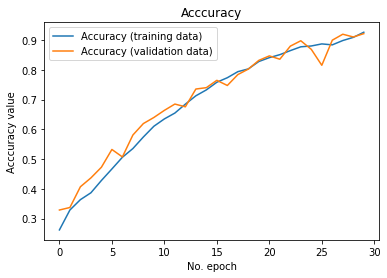

In [21]:
# Plot history: MAE
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Acccuracy')
plt.ylabel('Acccuracy value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [22]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

Text(91.68, 0.5, 'predicted label')

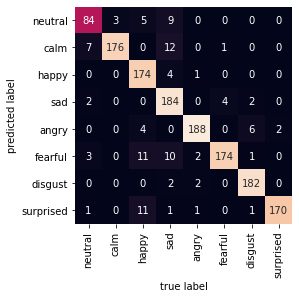

In [23]:

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']

x = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
           xticklabels = classes,
            yticklabels = classes
           )
plt.xlabel('true label')
plt.ylabel('predicted label')

### CNN model

In [24]:
X = X.reshape((X.shape[0],X.shape[1], X.shape[2], 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state =42)

In [25]:
## CNN model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

def get_2d_conv_model(inputs):
    ''' Create a standard deep 2D convolutional neural network'''
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape = inputs))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    # Full connection
    model.add(Dense(units = 256, activation = 'relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.5))
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units = 64, activation = 'relu'))
    
    model.add(Dense(units = 9, activation = 'softmax'))
    # Compiling the CNN
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [26]:

model = get_2d_conv_model((X.shape[1], X.shape[2],1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 282, 18, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 141, 9, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 139, 7, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 69, 3, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 67, 1, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 4288)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1

In [27]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30,
                  callbacks = [callback])

Epoch 1/30
324/324 [==============================] - 33s 54ms/step - loss: 2.5080 - accuracy: 0.2301 - val_loss: 1.5747 - val_accuracy: 0.4028
Epoch 2/30
324/324 [==============================] - 17s 52ms/step - loss: 1.5399 - accuracy: 0.4030 - val_loss: 1.2870 - val_accuracy: 0.5008
Epoch 3/30
324/324 [==============================] - 17s 52ms/step - loss: 1.2515 - accuracy: 0.5200 - val_loss: 1.0737 - val_accuracy: 0.6057
Epoch 4/30
324/324 [==============================] - 17s 52ms/step - loss: 1.0575 - accuracy: 0.6111 - val_loss: 0.9066 - val_accuracy: 0.6501
Epoch 5/30
324/324 [==============================] - 17s 52ms/step - loss: 0.9154 - accuracy: 0.6487 - val_loss: 0.7583 - val_accuracy: 0.7242
Epoch 6/30
324/324 [==============================] - 17s 52ms/step - loss: 0.7842 - accuracy: 0.7048 - val_loss: 0.6175 - val_accuracy: 0.7824
Epoch 7/30
324/324 [==============================] - 17s 52ms/step - loss: 0.6311 - accuracy: 0.7716 - val_loss: 0.5323 - val_accuracy:

In [28]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.9319444298744202


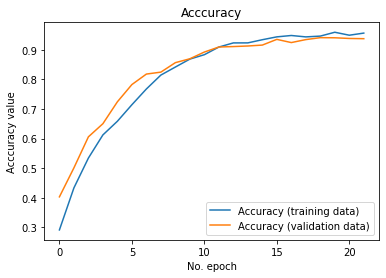

In [29]:
# Plot history: MAE
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Acccuracy')
plt.ylabel('Acccuracy value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [30]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

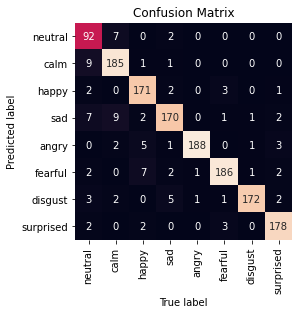

In [31]:

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']

x = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
           xticklabels = classes,
            yticklabels = classes
           )
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("Confusion Matrix")
plt.show()